In [1]:
import pandas as pd
import numpy as np
from data_prep import DataPrep
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator


In [ ]:
# Pipeline 
# 1. Use Classifiers to classify the returns (int)
# 2. Predict using data
# 3. Construct Porfolio Returns 

In [2]:
data_obj = DataPrep()
data_obj.data_initialization()
data_obj.data_construction()
id_df, feature_df, return_df = data_obj.data_slicing()

data initialized
DataFrame size: (4135225, 135)
data construction complete
DataFrame size: (987322, 137)


In [3]:
stock_df = data_obj.data_clean_na()

DataFrame size: (237608, 137)


In [71]:
np.array(stock_df[data_obj.ret_col])

array([[ 0.03873082],
       [ 0.06891708],
       [ 0.055353  ],
       ...,
       [-0.14449479],
       [-0.14718226],
       [-0.37071334]])

In [72]:
lda = LDA(n_components=1)
lda_result = lda.fit(X=stock_df[data_obj.feature_col], y=np.array(stock_df[data_obj.ret_col]))

/Users/pengjin/Desktop/ml_project/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


ValueError: Unknown label type: (array([ 0.03873082,  0.06891708,  0.055353  , ..., -0.14449479,
       -0.14718226, -0.37071334]),)

In [25]:
pca = PCA()   
stock_df_pca_model_obj = pca.fit(stock_df[data_obj.feature_col])

In [65]:
pca_index_val = np.arange(0, len(stock_df_pca_model_obj.explained_variance_ratio_), 1)
pca_index_rename = [f'comp_{i}' for i in pca_index_val]
pca_var = stock_df_pca_model_obj.explained_variance_ratio_
pca_cumu_var = stock_df_pca_model_obj.explained_variance_ratio_.cumsum()
pca_result_df = pd.DataFrame([pca_index_val, pca_index_rename, pca_var, pca_cumu_var]).T
pca_result_df.columns = ['index_values', 'renamed_columns', 'expl_var', 'expl_var_cumu']
# Find out when did we reach 80% explanation of variance
pca_result_df_80 = pca_result_df[pca_result_df.expl_var_cumu<=0.8].copy()
stock_df_trans = pd.DataFrame(data=pca.transform(stock_df[data_obj.feature_col]))
stock_df_trans_80 = stock_df_trans[pca_result_df_80.index_values]
stock_df_trans_80.columns = pca_result_df_80.renamed_columns
stock_df_trans_80 = pd.concat([stock_df[data_obj.id_columns].reset_index(), stock_df_trans_80.reset_index(), stock_df[data_obj.ret_col].reset_index()], axis=1)
class_bins = [-9999999]+[return_df['ret_exc_lead1m'].quantile(i) for i in np.arange(0,1,0.2)]+[9999999999]
stock_df_trans_80['ret_class'] = pd.cut(stock_df_trans_80['ret_exc_lead1m'], class_bins, labels=[1,2,3,4,5,6]).astype(int)

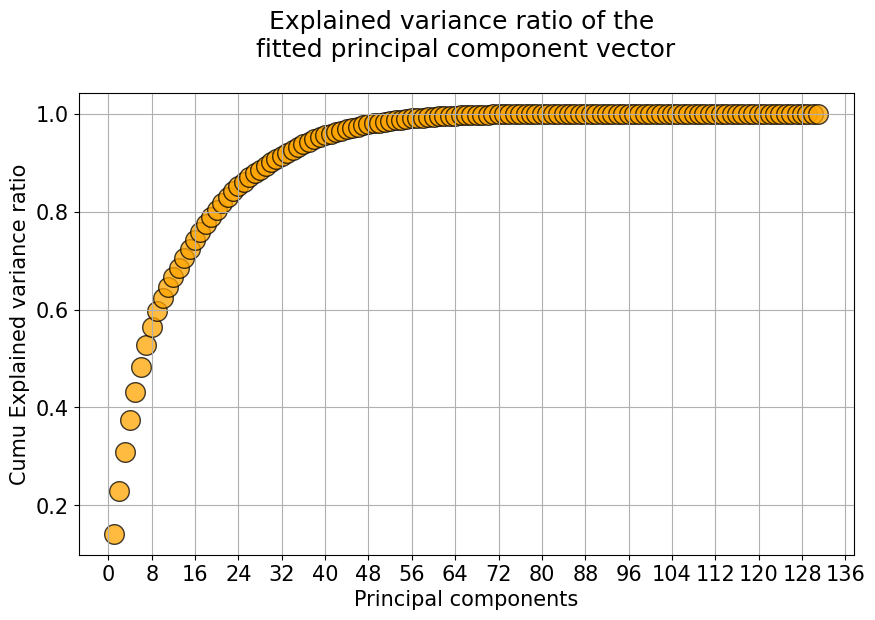

In [63]:
plt.figure(figsize=(10,6))
plt.scatter(x=[i+1 for i in range(len(stock_df_pca_model_obj.explained_variance_ratio_))],
            y=stock_df_pca_model_obj.explained_variance_ratio_.cumsum(),
           s=200, alpha=0.75,c='orange',edgecolor='k')
plt.grid(True)
plt.title("Explained variance ratio of the \nfitted principal component vector\n",fontsize=18)
plt.xlabel("Principal components",fontsize=15)
plt.xticks([i+1 for i in range(len(stock_df_pca_model_obj.explained_variance_ratio_))],fontsize=15)

# Setting x-ticks interval
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(8))  # Set interval of 1 to ensure each principal component is marked

plt.yticks(fontsize=15)
plt.ylabel("Cumu Explained variance ratio",fontsize=15)
plt.show()

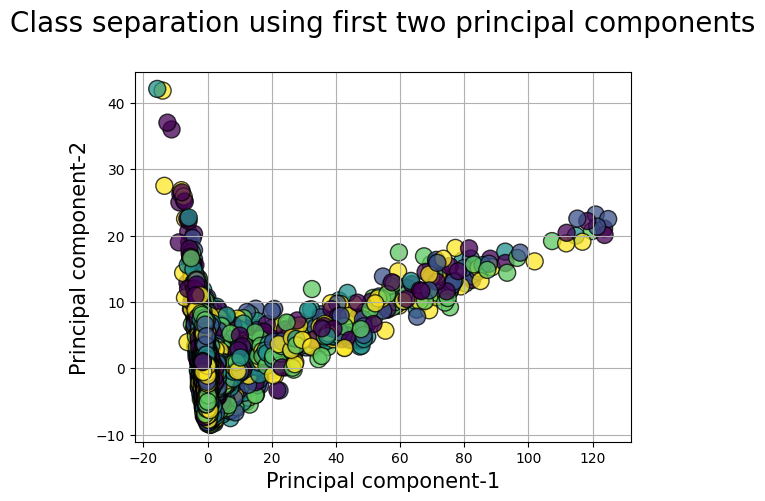

In [66]:
plt.scatter(stock_df_trans_80['comp_0'],stock_df_trans_80['comp_1'],c=stock_df_trans_80['ret_class'],edgecolors='k',alpha=0.75,s=150)
plt.grid(True)
plt.title("Class separation using first two principal components\n",fontsize=20)
plt.xlabel("Principal component-1",fontsize=15)
plt.ylabel("Principal component-2",fontsize=15)
plt.show()

In [61]:
stock_df_trans_80['comp_0'].describe()

count    2.376080e+05
mean    -2.105241e-17
std      2.592112e+00
min     -1.568303e+01
25%     -8.017662e-01
50%     -3.379852e-01
75%      2.046468e-01
max      1.248387e+02
Name: comp_0, dtype: float64